In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load data from CSV
data = pd.read_csv('LR_data.csv')
data

,Variant,Training,CancerPath,Path,Class,Activity,Abundance
0,G6D,1,Non-cancer,Benign,Benign,1.060842,0.915432
1,D38V,1,Non-cancer,Benign,Benign,0.832780,0.734458
2,K46E,1,Non-cancer,Benign,Benign,1.224551,1.238868
3,A45T,1,Non-cancer,Benign,Benign,1.131251,1.355233
4,D49G,1,Non-cancer,Benign,Benign,0.925693,0.829098
...,...,...,...,...,...,...,...
67,R97T,0,VUS,VUS,VUS,0.023563,0.815974
68,S456L,0,VUS,VUS,VUS,0.006592,0.003990
69,S509L,0,VUS,VUS,VUS,0.011433,0.834188
70,T143M,0,VUS,VUS,VUS,0.062968,0.127595


In [3]:
# Mapping class labels to numeric values
class_mapping = {'Cancer': 1, 'Non-cancer': 0}

# Encoding class labels
label_encoder = LabelEncoder()
data['CancerPath'] = label_encoder.fit_transform(data['CancerPath'].map(class_mapping))

# Extracting features
X_train = data[data['Training'] == 1][['Activity']]
y_train = data[data['Training'] == 1]['CancerPath']

In [4]:
# Create Activity logistic regression model
logreg = LogisticRegression(multi_class='ovr', solver='liblinear', penalty= 'l1', random_state=0, max_iter=500)

# Define parameter grid for grid search
param_grid = {
    'C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # Regularization strength 
}

In [5]:
# Get unique class labels from y
unique_labels = np.unique(y_train)

#Create custom scorer
custom_scorer = make_scorer(log_loss, needs_proba= True, greater_is_better=False, labels=unique_labels)

# Create grid search object with precision scoring
grid_search = GridSearchCV(logreg, param_grid, 
                           cv= RepeatedKFold(n_splits=5, n_repeats=5, random_state=0),
                           scoring=custom_scorer,
                           verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Output the best score
best_score = grid_search.best_score_
print("Best score from custom scorer:", best_score)

Fitting 25 folds for each of 10 candidates, totalling 250 fits
Best Hyperparameters: {'C': 40}
Best score from custom scorer: -0.0621243386224393


In [6]:
# Get best model
best_model = grid_search.best_estimator_

# Compute predicted probabilities of each class for all variants
X = data[['Activity']]
probabilities = best_model.predict_proba(X)

# Append predicted probabilities to the DataFrame
for i, class_name in enumerate(best_model.classes_):
    data[f'Probability_{class_name}'] = probabilities[:, i]
data

,Variant,Training,CancerPath,Path,Class,Activity,Abundance,Probability_0,Probability_1
0,G6D,1,0,Benign,Benign,1.060842,0.915432,1.000000,1.606389e-26
1,D38V,1,0,Benign,Benign,0.832780,0.734458,1.000000,1.561799e-20
2,K46E,1,0,Benign,Benign,1.224551,1.238868,1.000000,8.084690e-31
3,A45T,1,0,Benign,Benign,1.131251,1.355233,1.000000,2.276457e-28
4,D49G,1,0,Benign,Benign,0.925693,0.829098,1.000000,5.677868e-23
...,...,...,...,...,...,...,...,...,...
67,R97T,0,2,VUS,VUS,0.023563,0.815974,0.035067,9.649327e-01
68,S456L,0,2,VUS,VUS,0.006592,0.003990,0.012859,9.871410e-01
69,S509L,0,2,VUS,VUS,0.011433,0.834188,0.017156,9.828443e-01
70,T143M,0,2,VUS,VUS,0.062968,0.127595,0.282396,7.176035e-01


In [47]:
# Add a new column 'Odds_Ratio' to data
data['Odds_Ratio'] = data['Probability_1'] / data['Probability_0']

#Save data to file
data.to_csv('Activity CvNC LR_results.csv')
data

,Variant,Training,CancerPath,Path,Class,Activity,Abundance,Probability_0,Probability_1,Odds_Ratio
0,G6D,1,0,Benign,Benign,1.060842,0.915432,1.000000,1.606389e-26,1.606389e-26
1,D38V,1,0,Benign,Benign,0.832780,0.734458,1.000000,1.561799e-20,1.561799e-20
2,K46E,1,0,Benign,Benign,1.224551,1.238868,1.000000,8.084690e-31,8.084690e-31
3,A45T,1,0,Benign,Benign,1.131251,1.355233,1.000000,2.276457e-28,2.276457e-28
4,D49G,1,0,Benign,Benign,0.925693,0.829098,1.000000,5.677868e-23,5.677868e-23
...,...,...,...,...,...,...,...,...,...,...
67,R97T,0,2,VUS,VUS,0.023563,0.815974,0.035067,9.649327e-01,2.751661e+01
68,S456L,0,2,VUS,VUS,0.006592,0.003990,0.012859,9.871410e-01,7.676641e+01
69,S509L,0,2,VUS,VUS,0.011433,0.834188,0.017156,9.828443e-01,5.728963e+01
70,T143M,0,2,VUS,VUS,0.062968,0.127595,0.282396,7.176035e-01,2.541121e+00


In [8]:
# Initialize variables
desired_odds_ratios = {'PS3_strong_OR': 18.7, 'PS3_moderate_OR': 4.3}
thresholds = {}

# Generate X values
X_values = np.linspace(-.02, 1, 1000)

# Predict probabilities for positive class (1)
predicted_probabilities = best_model.predict_proba(X_values.reshape(-1, 1))[:, 1]

# Find the probability thresholds
for ratio_name, desired_odds_ratio in desired_odds_ratios.items():
    for i in range(len(predicted_probabilities) - 1, -1, -1):
        prob = predicted_probabilities[i]
        odds_ratio = prob / (1 - prob)  # Calculate odds ratio
        if odds_ratio >= desired_odds_ratio:
            thresholds[ratio_name] = X_values[i]
            break

# Print the thresholds
for ratio_name, threshold in thresholds.items():
    print(f"Threshold where {ratio_name} equals {desired_odds_ratios[ratio_name]}:", threshold)


Threshold where PS3_strong_OR equals 18.7: 0.029009009009009008
Threshold where PS3_moderate_OR equals 4.3: 0.05351351351351351


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


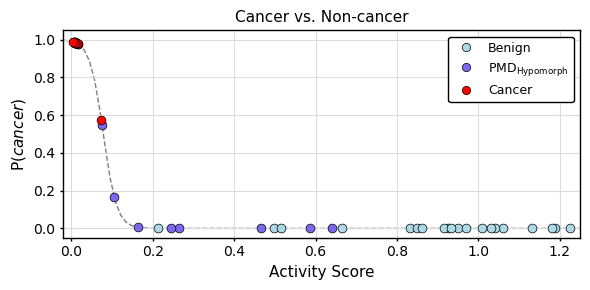

In [9]:
# Generate X values
X_values = np.linspace(-.02, 1.25, 100)

# Predict probabilities for positive class (1)
predicted_probabilities = best_model.predict_proba(X_values.reshape(-1, 1))[:, 1]

# Create the plot
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
plt.plot(X_values, predicted_probabilities, color='gray', linewidth=1, zorder=1, linestyle='--')

# Plot data points from dataframe
colors = {'Benign': 'lightblue', 'PMD': 'mediumslateblue', 'Cancer': 'red'}
for class_label, color in colors.items():
    class_data = data[data['Class'] == class_label]
    plt.scatter(class_data['Activity'],
                class_data['Probability_1'],
                color=color,
                edgecolor='black',
                linewidth=0.5,
                s=40,
                zorder=2)

# Set plot title and labels
plt.title('Cancer vs. Non-cancer', fontsize=11)
plt.xlabel('Activity Score', fontsize=11)
plt.ylabel('P($\mathit{cancer}$)', fontsize=11)

# Set X and Y axis limits
plt.xlim(-0.02, 1.25)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)


# Add legend
legend_labels = {'Benign': 'Benign', 'PMD': 'PMD$_{\mathregular{Hypomorph}}$', 'Cancer': 'Cancer'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markeredgecolor='black', markeredgewidth=0.5, markersize=6) for color in colors.values()]
plt.legend(legend_handles, legend_labels.values(), fontsize=9, loc='upper right', framealpha=1, facecolor='white', edgecolor='black')

# Set spines color and thickness
spines = ['top', 'bottom', 'left', 'right']
for spine in spines:
    plt.gca().spines[spine].set_color('black')
    plt.gca().spines[spine].set_linewidth(1)

plt.tick_params(axis='both', reset=True, top=False, right=False, direction='out', length=2, width=1, color='black', labelsize=10)
ax.set_facecolor("white")
plt.grid(color='gainsboro')

# Show plot
plt.tight_layout()
plt.show()

In [10]:
#fig.savefig('Activity_LR_CvNC_plot.png', format='png', dpi=1200)